## Stock Price Prediction and Visualization Project

## Introduction
I've been working on this exciting project where I aim to predict and visualize the closing prices of AAPL, which represents Apple Inc. Using Python and some powerful libraries, such as yfinance, pandas, and fastai, I've been able to fetch, process, and analyze historical stock price data, as well as create a machine learning model for predicting future prices.

## Project Overview

## Data Fetching and Preprocessing
First things first, I imported the necessary Python libraries, including os, yfinance, pandas, and fastai, to make all of this magic happen.

Next, I specified the stock symbol, which is 'AAPL,' to focus on Apple Inc.'s stock.

Then, I fetched the historical stock price data from Yahoo Finance. The data covers the period from January 1, 2010, to January 11, 2023. This data will be the foundation for our analysis.

To make our predictions even better, I performed some feature engineering. I calculated moving averages (MA) and exponential moving averages (EMA) with different window spans and added them as features to the dataset. Of course, I made sure to remove any missing data.

## Model Training
Now, onto the exciting part—model training!

I defined the dependent variable, which is the 'Close' price, representing the closing stock prices. For features, I selected 'Open,' 'High,' 'Low,' 'Volume,' 'MA50,' 'MA200,' 'EMA50,' and 'EMA200.' These features will help our machine learning model make accurate predictions.

To ensure that our model is robust, I split the dataset into training and validation sets.

Using Fastai's TabularPandas, I processed the data, including normalization, as a preprocessing step. This step prepares our data for training.

I also created data loaders (dls) to efficiently load and handle our data during model training.

## Model Building
With data ready, it's time to build our model!

I defined the model configuration, focusing on reduced dropout, to make sure our model generalizes well to new data.

Then, I created a tabular learner with a simpler architecture, consisting of two hidden layers. This learner will be responsible for learning from our data.

And the most exciting part—training the model! I trained it using the training data, specifying a learning rate and the number of epochs for training.

## Predictions
Now that our model is trained, it's time to put it to the test!

I prepared the data for predictions, specifically for the dates from January 2 to January 10, 2023. This will be our "testing" period.

Using the trained model, I obtained predictions on this test data.

## Visualization
To visualize our results, I created a comparison DataFrame. This DataFrame allows us to see how well our model's predictions align with the actual closing prices.

Then, I used matplotlib to create a comparison plot. This plot displays the actual closing prices as well as our model's predictions. I added labels, a title, a legend, grid lines, and adjusted the layout for better aesthetics.

And there you have it—the visual comparison of actual vs. predicted closing stock prices for AAPL during the specified date range (January 2-10, 2023).

[*********************100%%**********************]  1 of 1 completed


epoch,train_loss,valid_loss,_rmse,time
0,921.932922,2909.626709,53.940956,00:00
1,501.721802,2914.562988,53.986694,00:00
2,357.773407,2911.522217,53.958523,00:00
3,263.406311,2915.442139,53.994835,00:00
4,192.838974,2890.511230,53.763474,00:00
5,144.524490,326.232880,18.061918,00:00
6,103.603004,1184.437134,34.415653,00:00
7,90.611450,151.484146,12.307890,00:00
8,72.758835,6.579582,2.565069,00:00
9,62.631023,5.350273,2.313066,00:00


       Actual   Predicted
0  126.040001  129.239212
1  129.610001  128.438309
2  129.929993  128.180756
3  125.070000  129.934280
4  126.360001  126.364349
5  125.019997  125.377716
6  129.619995  127.496948
7  130.149994  132.227921
8  130.729996  129.797073


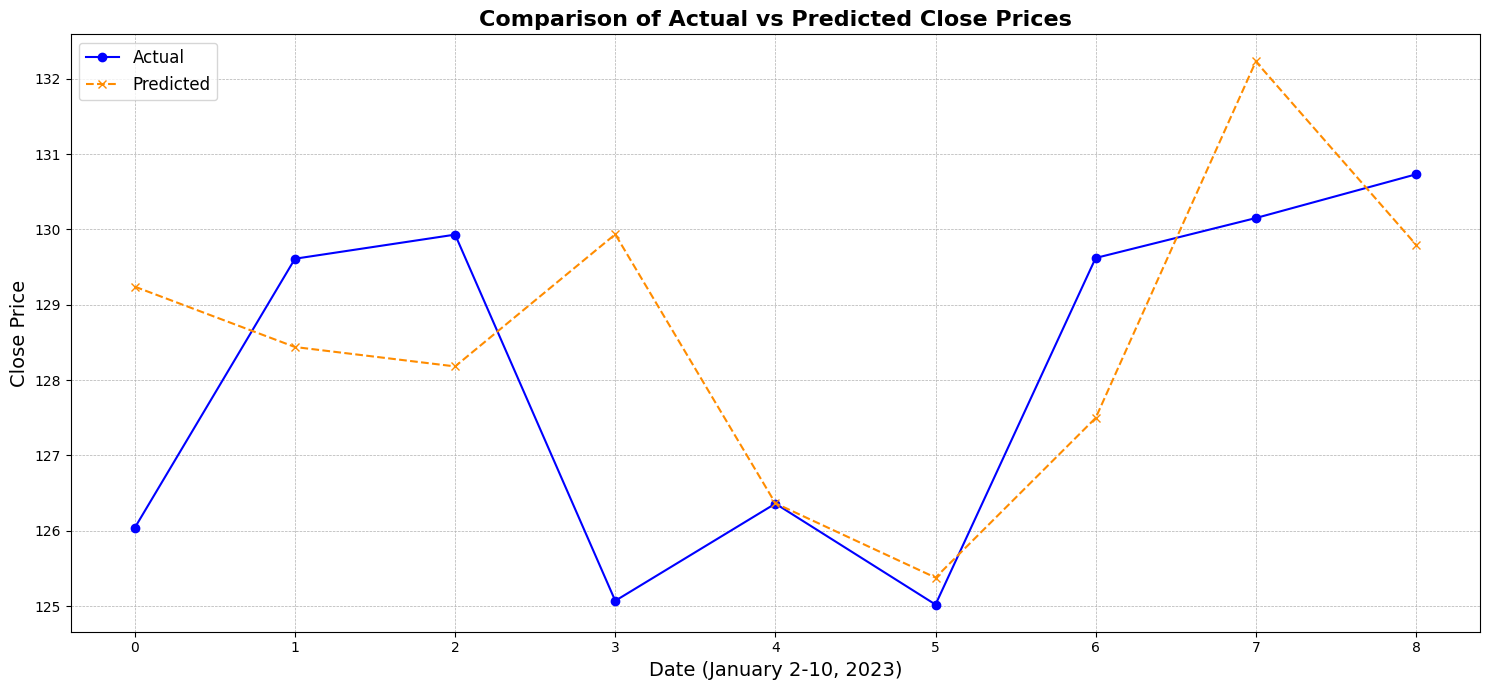

In [1]:
import os
import yfinance as yf
import pandas as pd
from fastai.tabular.all import *

# Define the stock symbol
symbol = 'AAPL'

# Fetch data
data = yf.download(symbol, start="2010-01-01", end="2023-01-11")

# Feature Engineering
data['MA50'] = data['Close'].rolling(window=50).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()
data.dropna(inplace=True)

# Model Training
dep_var = 'Close'
features = ['Open', 'High', 'Low', 'Volume', 'MA50', 'MA200', 'EMA50', 'EMA200']

# Split data for training and validation
train_idx = list(range(0, len(data) - 9))
valid_idx = list(range(len(data) - 9, len(data)))

to = TabularPandas(data, procs=[Normalize],
                   cont_names=features,
                   y_names=dep_var,
                   splits=(train_idx, valid_idx))

dls = to.dataloaders(bs=64)

# Define model configuration with reduced dropout
config = tabular_config(ps=[0.2, 0.2])

# Define the learner with a simpler architecture
learn = tabular_learner(dls, layers=[200, 100], config=config, metrics=rmse, y_range=(min(data[dep_var]), max(data[dep_var])))

# Use a slightly higher learning rate for training
lr_selected = 5e-3
learn.fit_one_cycle(10, lr_selected)

# Predictions for January 2-10, 2023
test_data = data.iloc[-9:]
dl = dls.test_dl(test_data)
predictions, actuals = learn.get_preds(dl=dl)

# Create a DataFrame to compare actual vs predicted prices
compare_df = pd.DataFrame({'Actual': actuals.numpy().squeeze(), 'Predicted': predictions.numpy().squeeze()})
print(compare_df)

# Enhanced plotting style with a title and improved aesthetics
plt.figure(figsize=(15, 7))

# Plotting the data
plt.plot(compare_df['Actual'], label='Actual', marker='o', linestyle='-', color='blue')
plt.plot(compare_df['Predicted'], label='Predicted', marker='x', linestyle='--', color='darkorange')

# Setting labels, title, and legend
plt.xlabel('Date (January 2-10, 2023)', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.title('Comparison of Actual vs Predicted Close Prices', fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=12)

# Enhancing the grid and layout
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()

